### Import libraries

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats as stats
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pylab as plt
sc.set_figure_params(dpi=200)

### Read in count matrix and AUCell matrix

In [3]:
data_counts = sc.read_h5ad("Discovery_cohort_counts.h5ad")

data_aucell = sc.read_h5ad("Discovery_cohort_AUCell.h5ad")
data_aucell.var.index = data_aucell.var.index.str.strip("(+)") #strip (+) from regulon name for convenience

### Set raw layer before normalization or standardization

In [3]:
data_counts.raw = data_counts 

data_aucell.raw = data_aucell

### Normalize, log-like transform, and scale counts ; only scale AUCell

In [4]:
#Count normalization/transformation
sc.pp.normalize_total(data_counts)
data_counts.X = np.arcsinh(data_counts.X)
sc.pp.scale(data_counts)

#AUCell standardization
sc.pp.scale(data_aucell)

### Generate low dimensional, batch-robust representation of data based off of regulon AUCell values

In [19]:
#Default PCA values without feature selection
sc.pp.pca(data_aucell)

In [20]:
#Calculate KNN based off of square root number of observations, in PCA space
sc.pp.neighbors(data_aucell,n_neighbors=np.sqrt(data_aucell.n_obs).astype(int))

In [ ]:
#Leiden community detection with a resolution of 2
#Doing this de novo requires aggregating some clusters to form biologically relevant population labels
sc.tl.leiden(data_aucell,resolution=2)

In [ ]:
#Perform UMAP on the data, given neighborhoods, with a min_dist of 0.15
sc.tl.umap(data_aucell,min_dist=0.15)

In [5]:
#Set .obsm for count AnnData object to the one calculated from AUCell matrix, this way we can analyze gene-level data with the batch-robust representation 
data_counts.obsm = data_aucell.obsm.copy()
data_counts.uns = data_aucell.uns.copy()

### Define gene signatures and calculate their enrichment

In [6]:
#Antigen presentation and processing/MHC I and II signature as defined in Table S6
meta_damage_response = ['MSLN','MUC5AC','AQP5','TACSTD2','FSCN1','TFF2','ANXA1','ANXA10','REG4','MUC17','S100P','GSDMB','GSDMD','IL18','RELB','MDK','AHR','PDX1']

In [24]:
#Score gene signature with a control size of 2000 using the normalized and transformed count values
sc.tl.score_genes(data_counts,meta_damage_response,score_name='Metaplasia and Damage Response',ctrl_size=2000,use_raw=False)

/home/bob/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bob/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
#Visualize this signature on the AUCell-based UMAP
sc.pl.umap(data_counts,color=['Metaplasia and Damage Response'],use_raw=False)

### Define biologically relevant single-cell populations through leiden clustering and GSEA

In [ ]:
#Visualize this signature on the AUCell-based UMAP
sc.pl.umap(data_counts,color=['leiden'],use_raw=False)

In [16]:
#Differential gene expression testing using the .raw values
sc.tl.rank_genes_groups(data_counts,groupby='leiden',use_raw=True,n_genes=200,method='wilcoxon')

/home/bob/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [ ]:
#Show differential gene expression results
sc.pl.rank_genes_groups(data_counts)

In [ ]:
#Perform GSEA using differentially expressed genes from leiden group 1 for example
sc.queries.enrich(data_counts,group='1')

In [ ]:
#Based off of above, relabel leiden clusters to biologically relevant types
data_counts.obs['Cell Type'] = data_counts.obs['leiden'].replace({'1':'STM',
                                                                  '2':'ASC',
                                                                  '3':'SSC',
                                                                  '4':'SSC' #and so on
                                                                 })

### Generate heatmap with marker genes

In [11]:
#Based on above and literature review, these gene lists were determined to be highly specific to certain single-cell populations
marker_genes={
    'CT':['OTOP2','MEIS1'],
    'ABS':['KRT20','GUCA2A','ALDOB'],
    'SSC':['MSLN','MUC5AC','AQP5','TACSTD2','FSCN1','TFF2','ANXA1','ANXA10','REG4','MUC17','S100P','GSDMB','GSDMD','IL18','RELB','MDK','RARA','RXRA','AHR','AGRN','PDX1'],
    'ASC':['CLDN2','CD44','AXIN2','RNF43','TGFBI','EPHB2','TEAD2','CDX2'],
    'STM':['LGR5','OLFM4','ASCL2'],
    'TAC':['PCNA','MKI67'],
    'GOB':['ATOH1','MUC2','TFF3'],
    'EE':['CHGA','NEUROD1'],
    'TUF':['POU2F3','SOX9'],
}

/home/bob/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/bob/anaconda3/envs/qc_pipe/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


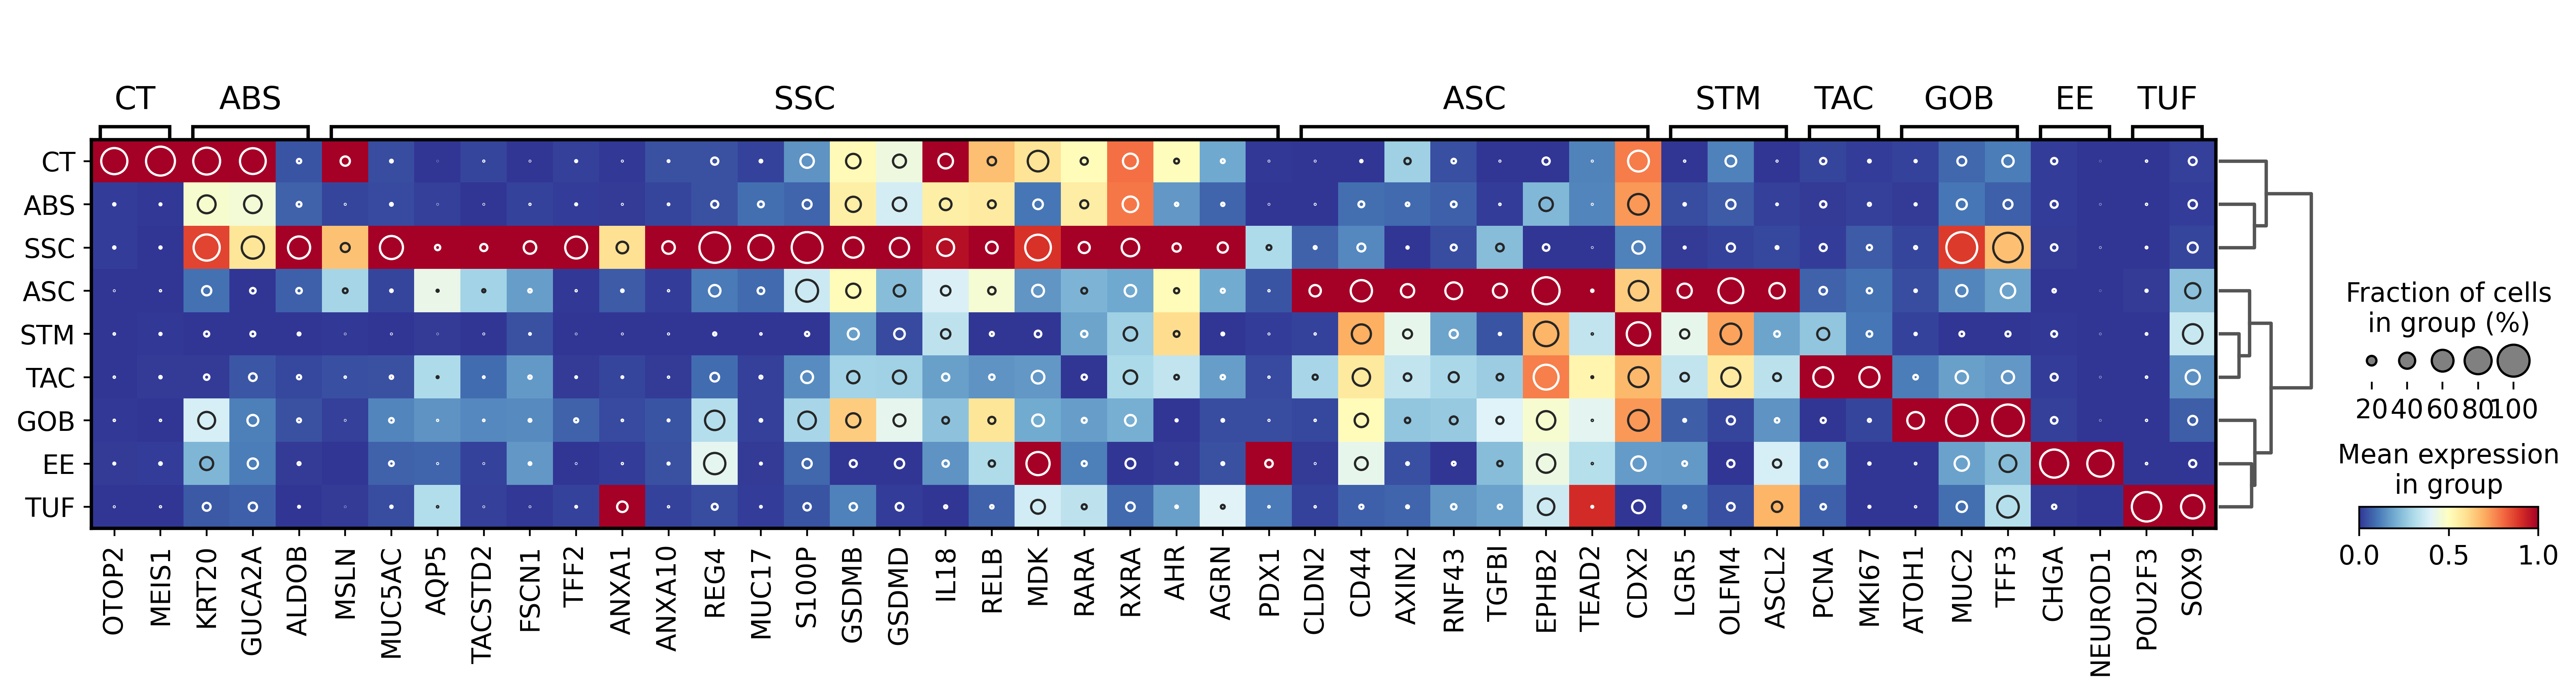

In [18]:
#Show differential gene expression results
dp = sc.pl.dotplot(data_counts,var_names=marker_genes,groupby='Cell Type',dendrogram=True,standard_scale='var',use_raw=False,var_group_rotation=0,swap_axes=False,return_fig=True)
dp.style(cmap='RdYlBu_r',color_on='square',dot_edge_color=None,dot_edge_lw=1).show()

### Gene signature visualization per defined population

In [25]:
#Retrieve signature scores and cell type labels per single cell
sig_scores = data_counts.obs[['Metaplasia and Damage Response','Cell Type']]

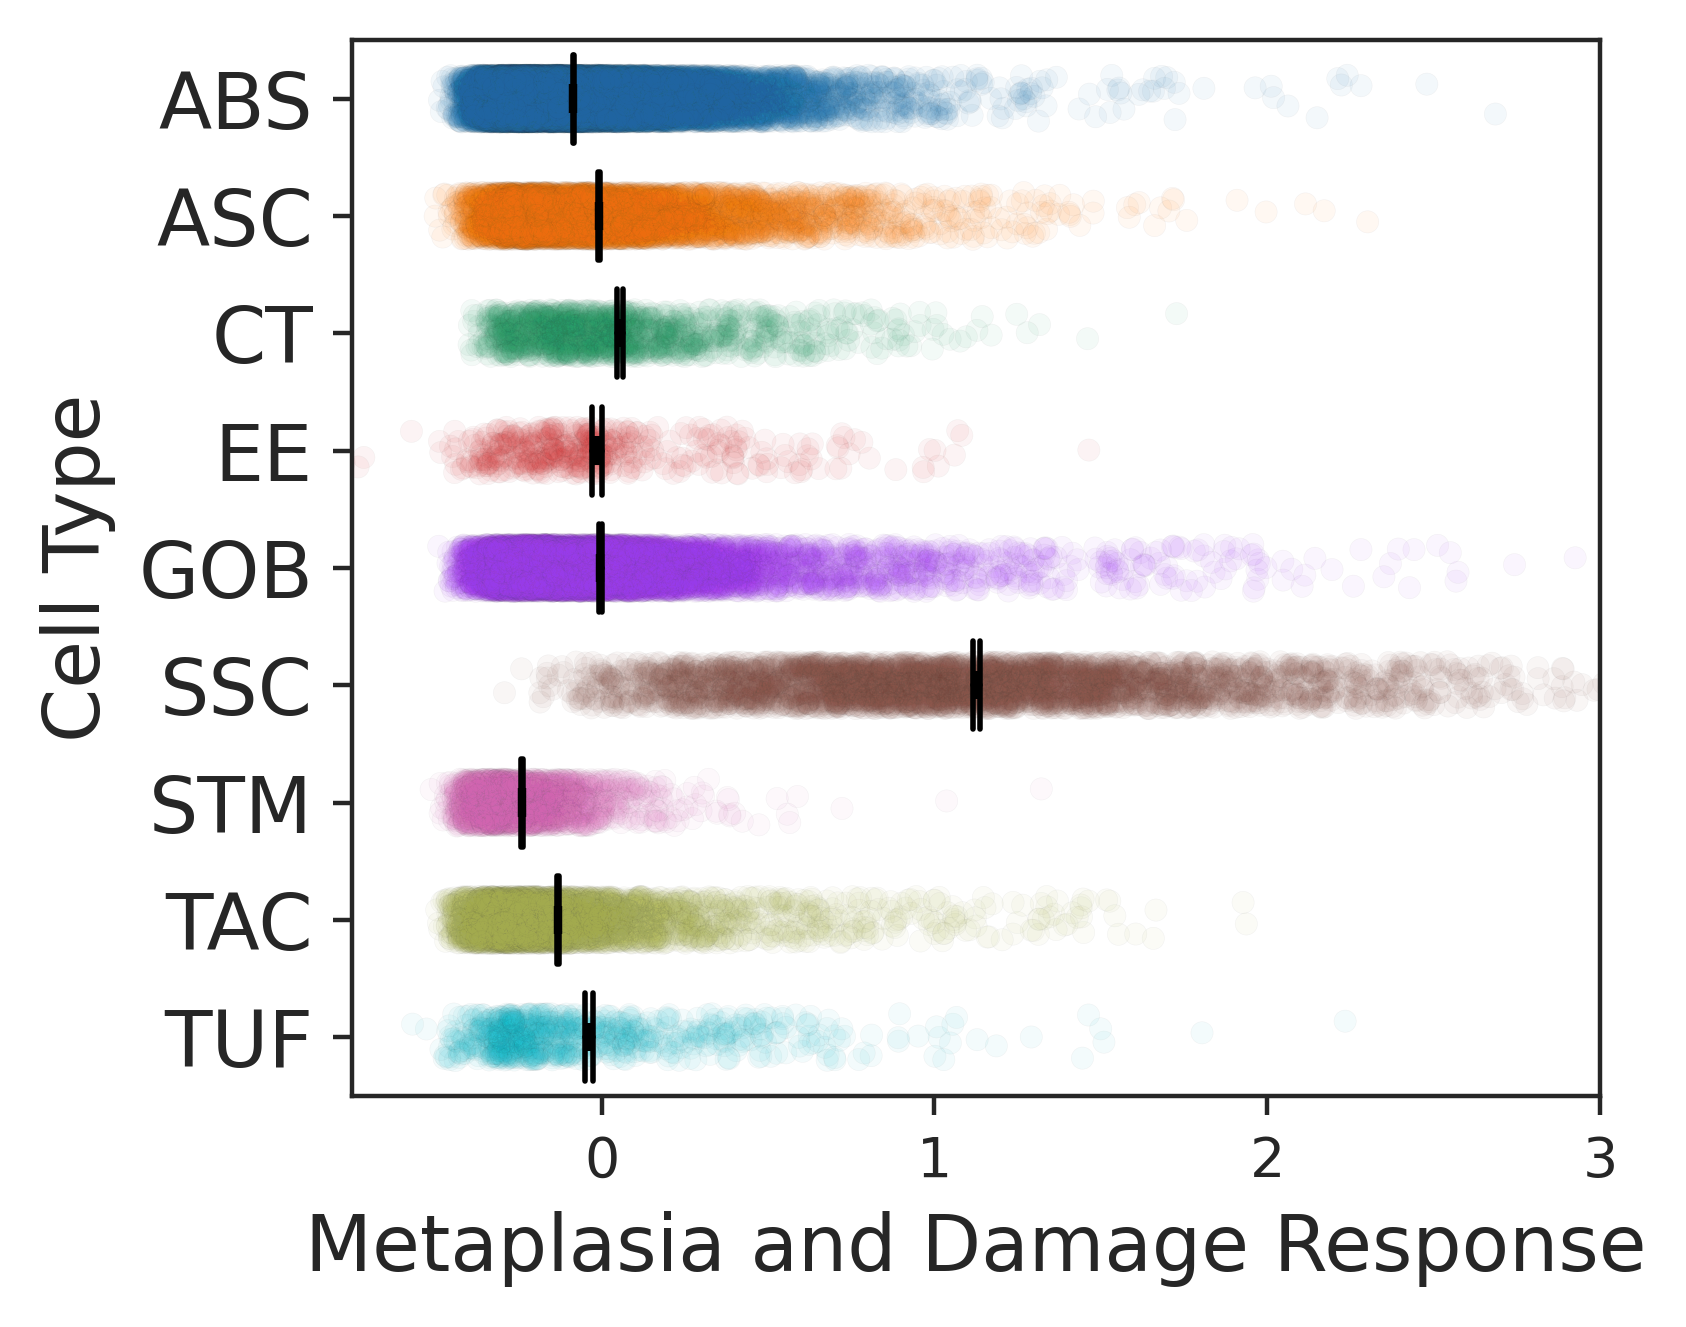

In [32]:
#Plot stripplot of the single-cell data
sns.set_style('ticks')
fig = plt.figure(figsize=(4,4))
jitter = 0.2
linewidth = 0.1
size = 4
labelsize=10
ci=68

ax = fig.add_subplot(1,1,1)
sns.stripplot(x="Metaplasia and Damage Response", y="Cell Type", data=sig_scores,ax=ax,orient='h',size=size,zorder=0,linewidth=linewidth,jitter=jitter,alpha=0.05)
sns.pointplot(x="Metaplasia and Damage Response", y="Cell Type", data=sig_scores,ax=ax,orient='h',palette=['black'],capsize=0.75,errwidth=1,ci=68,markers='|',zorder=10,scale=0.75) #Mean indicator with SEM
ax.tick_params(axis='x',labelsize=labelsize)
ax.set(ylabel='Cell Type',xlim=(-0.75,3)) #set this based on the outlier values

plt.subplots_adjust(bottom=0.25,wspace=0.25)
plt.show()

### Statistical testing of value distributions per single-cell population

In [ ]:
#Split up scores per cell type and perform non-parametric test
signature_split = [sig_scores[sig_scores['Cell Type']==i]['Metaplasia and Damage Response'] for i in sig_scores['Cell Type'].unique()]
stats.kruskal(signature_split[0],signature_split[1],signature_split[2],signature_split[3],signature_split[4],signature_split[5],signature_split[6],signature_split[7],signature_split[8])

In [ ]:
#If above is significant, null hypothesis is rejected, and pairwise post-hoc tests should be performed, with appropriate p value adjustment
sp.posthoc_mannwhitney(sig_scores,val_col='Metaplasia and Damage Response',group_col='Cell Type',sort=False,p_adjust='fdr_bh')

### Contingency table generation

In [ ]:
contingency_table = pd.crosstab(data_aucell.obs['SPECID'],data_aucell.obs['Cell Type'],normalize=True)
contingency_table

### Plotting colors

In [18]:
#color dictionaries/hex codes for labeling sample types
color_dict_sample_type = {
    'HP':'#ff287f', 
    'UNC':'#ffed82', 
    'NL':'#97979E',  
    'SSL':'#fe8cff', 
    'TA':'#0000ff',
    'TVA':'#751a41',
}

adata.uns['Sample_Type_colors'] = ['#ff287f', '#97979E', '#fe8cff', '#0000ff', '#751a41', '#ffed82']

In [19]:
#color dictionaries/hex codes for labeling cell types
color_dict_cell_type = {
    'GOB':'#1f77b4', 
    'TAC':'#d62728', 
    'ASC':'#b5bd61', 
    'TUF':'#8c564b', 
    'ABS':'#63b850', 
    'STM':'#aa40fc', 
    'SSC':'#e377c2', 
    'EE':'#ff7f0e', 
    'CT':'#17becf'
}

adata.uns['Cell_Type_colors'] = ['#63b850', '#b5bd61', '#17becf', '#ff7f0e', '#1f77b4', '#e377c2', '#aa40fc', '#d62728', '#8c564b']

### Cell cycle reference list

In [1]:
#cell cycle list to be used with sc.tl.score_genes_cell_cycle function
cycle_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8','HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
s_genes = cycle_genes[:43]
g2m_genes = cycle_genes[43:]